# Bed simulation

In [13]:
simulationStore = []

In [14]:
df.shape

(7704, 8)

In [15]:
df.columns

Index(['oasis_resprate', 'oasis_meanbp', 'oasis_heartrate',
       'oasis_urineoutput', 'hospital_expire_flag', 'days_survived',
       'icustay_boarder_initial', 'changed_hospital_expire_flag'],
      dtype='object')

In [16]:
df = pd.read_csv('data_results.csv')

In [28]:
"""
Bed counter-factual Simulation

Covers:

- Resources: Resource
- Resources: Container
- Waiting for other processes

Scenario:
    We are trying to assess if using a non-greedy approach would
     reduce the number of patients boarded to the wrong ward

- A patient arrives at the beds_correct - the logic!
beds = simulated_beds + remaining_beds

# If there are no beds in the correct specialty area irl
if remaining_beds=0:
    boarded = True
else:
    boarded = False
# If there are no beds in the simulation for the correct specialty area
if beds <= 0 | predicted_board:
    simulation_boarded = True
else:
    simulation_boarded = False

if simulation_boarded & boarded:
    wait for a bit
    leave
if simulation_boarded & not boarded:
    increment simulated beds
    wait for a bit
    leave
if not simulation_boarded & boarded:
    decrement simulation beds
    wait for a bit
if not simulation_boarded & not boarded:  # repeated for readability...
    wait for a bit
    leave
"""
import itertools
import random
import pandas as pd
import numpy as np
import simpy


RANDOM_SEED = 42
T_INTER = [30, 30]        # Create a patient every [min, max] minutes
SIM_TIME = 30*7704 + 30          # Simulation time in minutes
NUMBER_OF_BEDS = 200

df = pd.read_csv('data_results.csv')
#df['changed_hospital_survival'] = np.random.uniform(low=0, high=1, size=(df.shape[0],))
#df['changed_hospital_survival'] = np.random.lognormal(mean=0.3, sigma=1)
#df['changed_hospital_survival'] = df['changed_hospital_survival'].apply(lambda x: (1 if x > 1 else x))

df['changed_hospital_survival'] = df['changed_hospital_expire_flag']#.apply(lambda x: 0 if x < 0 else x)
df['predicted_boarded'] = df['changed_hospital_survival'].apply(lambda x: x > 0.005)
#df['mort'] = df['days_survived'].apply(lambda x: x <= 30)
df['transfers.subject_id'] = np.arange(0, df.shape[0])
df['icustay_los_total'] = np.arange(0, df.shape[0])
patients = df.to_dict(orient='records')

# Toy data
#patients = [{'transfers.subject_id': 1, 'icustay_los_total': 50, 'remaining_beds': 6, 'predicted_boarded': False},
#            {'transfers.subject_id': 2, 'icustay_los_total': 30, 'remaining_beds': 6, 'predicted_boarded': False}]


global simulated_beds
simulated_beds = 0
dayschangedStore = []
agreementStore = []


def patient(env, beds_correct, **p):
    global simulated_beds
    print('%s arriving at ICU at %.1f' % (p['transfers.subject_id'], env.now))

    beds = simulated_beds + p['remaining_beds']
    print("beds",beds, simulated_beds)
    if p['icustay_boarder_initial'] == 1:
        boarded = True
    else:
        boarded = False

    # If there are no beds in the simulation for the correct specialty area
    if p['predicted_boarded']:
        simulation_boarded = True
    else:
        simulation_boarded = False
        print("Became false!", p['predicted_boarded'], beds)

    if simulation_boarded & boarded:
        print("Agreed boarding")
        agreementStore.append("Agreed boarding")
        dayschangedStore.append(0)
        with beds_correct.request() as req:
            start = env.now
            # Request one of the beds
            yield req
            # Stay in a bed for a bit
            yield env.timeout(p['icustay_los_total'])
            print('%s left ward in %.1f minutes.' % (p['transfers.subject_id'], env.now - start))

    elif simulation_boarded & (not boarded):
        print("Disagree boarding")
        agreementStore.append("Disagree boarding")
        dayschangedStore.append(p['changed_hospital_survival'])
        with beds_correct.request() as req:
            start = env.now
            simulated_beds += 1
            # Request one of the beds
            yield req
            # Stay in a bed for a bit
            yield env.timeout(p['icustay_los_total'])
            #simulated_beds -= 1
            print('%s left ward in %.1f minutes.' % (p['transfers.subject_id'], env.now - start))

    elif (not simulation_boarded) and boarded:
        print(beds)
        if beds > 0:
            print("Disagree not boarding, boarding")
            agreementStore.append("Disagree not boarding")
            dayschangedStore.append(p['changed_hospital_survival'])
            with beds_correct.request() as req:
                start = env.now
                simulated_beds -= 1
                # Request one of the beds
                yield req
                # Stay in a bed for a bit
                yield env.timeout(p['icustay_los_total'])
                simulated_beds += 1
                print('%s left ward in %.1f minutes.' % (p['transfers.subject_id'], env.now - start))
        else:
            print("Not enough beds")
            agreementStore.append("Agreed boarding")
            dayschangedStore.append(0)
            with beds_correct.request() as req:
                start = env.now
                # Request one of the beds
                yield req
                # Stay in a bed for a bit
                yield env.timeout(p['icustay_los_total'])
                print('%s left ward in %.1f minutes.' % (p['transfers.subject_id'], env.now - start))


    elif (not simulation_boarded) and (not boarded):
        if beds > 0:
            print("Agreed not boarding")
            agreementStore.append("Agreed not boarding")
            dayschangedStore.append(p['changed_hospital_survival'])
            with beds_correct.request() as req:
                start = env.now
                # Request one of the beds
                yield req
                # Stay in a bed for a bit
                yield env.timeout(p['icustay_los_total'])
                print('%s left ward in %.1f minutes.' % (p['transfers.subject_id'], env.now - start))
        else:
            print("Not enough beds, boarding")
            agreementStore.append("Disagree boarding")
            dayschangedStore.append(0)
            with beds_correct.request() as req:
                start = env.now
                # Request one of the beds
                yield req
                # Stay in a bed for a bit
                yield env.timeout(p['icustay_los_total'])
                print('%s left ward in %.1f minutes.' % (p['transfers.subject_id'], env.now - start))




def patient_generator(env, beds_correct, patients):
    """Generate new patient that arrive at the ICU."""
    for i in itertools.count():
        yield env.timeout(random.randint(*T_INTER))
        p = random.sample(patients, 1)[0]
        #print_name = 'Simulation id {}'.format(i) #, Data id  %s' % (i, p['transfers.subject_id'])
        env.process(patient(env, beds_correct, **p))


# Create environment and start processes
env = simpy.Environment()
beds_correct = simpy.Resource(env, NUMBER_OF_BEDS)
#bed_boarded = simpy.Resource(env, 1, NUMBER_OF_BEDS)
env.process(patient_generator(env, beds_correct, patients)) #beds_boarded,

# Execute!
env.run(until=SIM_TIME)

print(simulated_beds)




3162 arriving at ICU at 30.0
beds 3 0
Disagree boarding
5364 arriving at ICU at 60.0
beds 3 1
Disagree boarding
1283 arriving at ICU at 90.0
beds 3 2
Agreed boarding
720 arriving at ICU at 120.0
beds 5 2
Became false! False 5
Agreed not boarding
5408 arriving at ICU at 150.0
beds 3 2
Disagree boarding
2450 arriving at ICU at 180.0
beds 4 3
Disagree boarding
1383 arriving at ICU at 210.0
beds 6 4
Agreed boarding
744 arriving at ICU at 240.0
beds 7 4
Disagree boarding
1735 arriving at ICU at 270.0
beds 7 5
Became false! False 7
Agreed not boarding
4808 arriving at ICU at 300.0
beds 7 5
Became false! False 7
Agreed not boarding
2920 arriving at ICU at 330.0
beds 7 5
Became false! False 7
7
Disagree not boarding, boarding
4810 arriving at ICU at 360.0
beds 12 4
Disagree boarding
5090 arriving at ICU at 390.0
beds 7 5
Disagree boarding
2231 arriving at ICU at 420.0
beds 7 6
Became false! False 7
Agreed not boarding
7457 arriving at ICU at 450.0
beds 11 6
Disagree boarding
298 arriving at IC

5813 arriving at ICU at 7950.0
beds 98 97
Disagree boarding
6889 left ward in 6889.0 minutes.
3034 arriving at ICU at 7980.0
beds 102 98
Disagree boarding
5561 left ward in 5561.0 minutes.
6373 left ward in 6373.0 minutes.
922 arriving at ICU at 8010.0
beds 104 99
Disagree boarding
7647 arriving at ICU at 8040.0
beds 102 100
Disagree boarding
4709 arriving at ICU at 8070.0
beds 103 101
Disagree boarding
2309 arriving at ICU at 8100.0
beds 105 102
Disagree boarding
1894 left ward in 1894.0 minutes.
2624 arriving at ICU at 8130.0
beds 105 103
Became false! False 105
Agreed not boarding
6543 arriving at ICU at 8160.0
beds 105 103
Became false! False 105
Agreed not boarding
4537 left ward in 4537.0 minutes.
2320 arriving at ICU at 8190.0
beds 107 103
Disagree boarding
2691 left ward in 2691.0 minutes.
6708 arriving at ICU at 8220.0
beds 107 105
Disagree boarding
7689 left ward in 7689.0 minutes.
1444 arriving at ICU at 8250.0
beds 110 106
Became false! False 110
Agreed not boarding
3257 le

Became false! False 157
Agreed not boarding
3227 left ward in 3227.0 minutes.
3622 arriving at ICU at 12000.0
beds 156 154
Became false! False 156
Agreed not boarding
4796 left ward in 4796.0 minutes.
1873 arriving at ICU at 12030.0
beds 157 154
Became false! False 157
Agreed not boarding
983 arriving at ICU at 12060.0
beds 157 154
Disagree boarding
1419 arriving at ICU at 12090.0
beds 157 155
Agreed boarding
5917 left ward in 5917.0 minutes.
4769 left ward in 4769.0 minutes.
7661 arriving at ICU at 12120.0
beds 155 155
Agreed boarding
3667 left ward in 3667.0 minutes.
2115 left ward in 2115.0 minutes.
599 arriving at ICU at 12150.0
beds 156 155
Became false! False 156
Agreed not boarding
3584 left ward in 3584.0 minutes.
495 arriving at ICU at 12180.0
beds 158 155
Became false! False 158
Agreed not boarding
6226 left ward in 6226.0 minutes.
2829 arriving at ICU at 12210.0
beds 161 155
Became false! False 161
Agreed not boarding
5406 left ward in 5406.0 minutes.
1636 arriving at ICU at

1472 arriving at ICU at 17880.0
beds 219 218
Disagree boarding
2551 left ward in 2551.0 minutes.
1803 left ward in 1803.0 minutes.
5690 arriving at ICU at 17910.0
beds 222 219
Became false! False 222
Agreed not boarding
7204 left ward in 7204.0 minutes.
3444 left ward in 3444.0 minutes.
3700 arriving at ICU at 17940.0
beds 219 219
Became false! False 219
219
Disagree not boarding, boarding
6028 left ward in 6028.0 minutes.
2337 arriving at ICU at 17970.0
beds 222 218
Became false! False 222
Agreed not boarding
1860 left ward in 1860.0 minutes.
1255 arriving at ICU at 18000.0
beds 219 218
Became false! False 219
219
Disagree not boarding, boarding
3041 arriving at ICU at 18030.0
beds 223 217
Disagree boarding
3052 arriving at ICU at 18060.0
beds 220 218
Disagree boarding
533 left ward in 533.0 minutes.
5129 left ward in 5129.0 minutes.
3069 arriving at ICU at 18090.0
beds 222 219
Became false! False 222
Agreed not boarding
2692 left ward in 2692.0 minutes.
2364 arriving at ICU at 18120.

6764 left ward in 6764.0 minutes.
2742 arriving at ICU at 23910.0
beds 313 310
Disagree boarding
6028 arriving at ICU at 23940.0
beds 312 311
Became false! False 312
Agreed not boarding
2913 left ward in 2913.0 minutes.
2866 arriving at ICU at 23970.0
beds 313 311
Disagree boarding
6722 left ward in 6722.0 minutes.
5552 left ward in 5552.0 minutes.
1308 arriving at ICU at 24000.0
beds 319 312
Became false! False 319
Agreed not boarding
6209 left ward in 6209.0 minutes.
3415 arriving at ICU at 24030.0
beds 313 312
Became false! False 313
Agreed not boarding
7023 left ward in 7023.0 minutes.
5117 left ward in 5117.0 minutes.
906 arriving at ICU at 24060.0
beds 313 312
Became false! False 313
Agreed not boarding
6131 arriving at ICU at 24090.0
beds 315 312
Became false! False 315
Agreed not boarding
7198 left ward in 7198.0 minutes.
4943 arriving at ICU at 24120.0
beds 319 312
Disagree boarding
6294 left ward in 6294.0 minutes.
2624 arriving at ICU at 24150.0
beds 315 313
Became false! Fa

Agreed boarding
6598 left ward in 6598.0 minutes.
6804 arriving at ICU at 27930.0
beds 369 366
Disagree boarding
3062 left ward in 3062.0 minutes.
2019 left ward in 2019.0 minutes.
7322 arriving at ICU at 27960.0
beds 373 368
Disagree boarding
2795 arriving at ICU at 27990.0
beds 375 369
Became false! False 375
Agreed not boarding
5859 arriving at ICU at 28020.0
beds 375 369
Became false! False 375
Agreed not boarding
2118 arriving at ICU at 28050.0
beds 369 369
Agreed boarding
520 left ward in 520.0 minutes.
1031 left ward in 1031.0 minutes.
829 left ward in 829.0 minutes.
3149 left ward in 3149.0 minutes.
5490 arriving at ICU at 28080.0
beds 374 370
Became false! False 374
Agreed not boarding
882 left ward in 882.0 minutes.
3291 arriving at ICU at 28110.0
beds 371 370
Disagree boarding
3599 left ward in 3599.0 minutes.
5653 arriving at ICU at 28140.0
beds 372 371
Disagree boarding
123 arriving at ICU at 28170.0
beds 374 372
Became false! False 374
Agreed not boarding
5344 left ward i

5684 arriving at ICU at 35040.0
beds 469 466
Disagree boarding
6323 left ward in 6323.0 minutes.
1195 left ward in 1195.0 minutes.
4719 arriving at ICU at 35070.0
beds 471 467
Became false! False 471
Agreed not boarding
5551 left ward in 5551.0 minutes.
5606 left ward in 5606.0 minutes.
5238 arriving at ICU at 35100.0
beds 467 467
Became false! False 467
467
Disagree not boarding, boarding
124 left ward in 124.0 minutes.
1543 arriving at ICU at 35130.0
beds 468 466
Agreed boarding
4949 left ward in 4949.0 minutes.
7190 arriving at ICU at 35160.0
beds 469 467
Disagree boarding
6923 arriving at ICU at 35190.0
beds 469 468
Became false! False 469
469
Disagree not boarding, boarding
5233 arriving at ICU at 35220.0
beds 469 467
Became false! False 469
469
Disagree not boarding, boarding
1206 arriving at ICU at 35250.0
beds 468 466
Disagree boarding
449 arriving at ICU at 35280.0
beds 469 467
Became false! False 469
Agreed not boarding
7322 left ward in 7322.0 minutes.
7127 arriving at ICU a

beds 531 529
Disagree boarding
3695 left ward in 3695.0 minutes.
1077 left ward in 1077.0 minutes.
1578 arriving at ICU at 39930.0
beds 535 532
Disagree boarding
1971 left ward in 1971.0 minutes.
4933 arriving at ICU at 39960.0
beds 538 533
Disagree boarding
7659 left ward in 7659.0 minutes.
4515 left ward in 4515.0 minutes.
3855 left ward in 3855.0 minutes.
2128 left ward in 2128.0 minutes.
1028 arriving at ICU at 39990.0
beds 535 534
Disagree boarding
6468 arriving at ICU at 40020.0
beds 540 535
Became false! False 540
Agreed not boarding
704 left ward in 704.0 minutes.
4075 arriving at ICU at 40050.0
beds 537 536
Became false! False 537
537
Disagree not boarding, boarding
2758 left ward in 2758.0 minutes.
240 arriving at ICU at 40080.0
beds 536 535
Disagree boarding
6016 left ward in 6016.0 minutes.
6383 arriving at ICU at 40110.0
beds 542 536
Became false! False 542
Agreed not boarding
6819 left ward in 6819.0 minutes.
360 left ward in 360.0 minutes.
3126 arriving at ICU at 40140.0

Became false! False 628
Agreed not boarding
4716 left ward in 4716.0 minutes.
7385 arriving at ICU at 46020.0
beds 629 628
Disagree boarding
364 left ward in 364.0 minutes.
6859 left ward in 6859.0 minutes.
2788 arriving at ICU at 46050.0
beds 634 629
Became false! False 634
Agreed not boarding
6244 left ward in 6244.0 minutes.
1016 left ward in 1016.0 minutes.
3388 left ward in 3388.0 minutes.
1877 arriving at ICU at 46080.0
beds 630 630
Became false! False 630
630
Disagree not boarding, boarding
5666 arriving at ICU at 46110.0
beds 629 629
Agreed boarding
7112 arriving at ICU at 46140.0
beds 634 629
Became false! False 634
Agreed not boarding
3735 left ward in 3735.0 minutes.
1109 arriving at ICU at 46170.0
beds 629 629
Became false! False 629
629
Disagree not boarding, boarding
5205 left ward in 5205.0 minutes.
4156 arriving at ICU at 46200.0
beds 630 628
Became false! False 630
Agreed not boarding
4725 left ward in 4725.0 minutes.
2386 left ward in 2386.0 minutes.
2326 left ward in

beds 679 674
Disagree boarding
6975 left ward in 6975.0 minutes.
2188 left ward in 2188.0 minutes.
6325 arriving at ICU at 49980.0
beds 676 675
Disagree boarding
7657 left ward in 7657.0 minutes.
1889 left ward in 1889.0 minutes.
2049 arriving at ICU at 50010.0
beds 679 676
Became false! False 679
679
Disagree not boarding, boarding
5159 left ward in 5159.0 minutes.
798 arriving at ICU at 50040.0
beds 682 675
Disagree boarding
1872 arriving at ICU at 50070.0
beds 680 676
Disagree boarding
6108 left ward in 6108.0 minutes.
5810 arriving at ICU at 50100.0
beds 677 677
Became false! False 677
677
Disagree not boarding, boarding
3139 left ward in 3139.0 minutes.
2890 arriving at ICU at 50130.0
beds 682 676
Disagree boarding
3388 arriving at ICU at 50160.0
beds 680 677
Became false! False 680
Agreed not boarding
4408 left ward in 4408.0 minutes.
740 arriving at ICU at 50190.0
beds 678 677
Disagree boarding
6083 arriving at ICU at 50220.0
beds 679 678
Disagree boarding
3778 left ward in 3778

737
Disagree not boarding, boarding
1091 left ward in 1091.0 minutes.
4780 arriving at ICU at 53970.0
beds 741 736
Became false! False 741
Agreed not boarding
2432 arriving at ICU at 54000.0
beds 739 736
Disagree boarding
5419 arriving at ICU at 54030.0
beds 740 737
Disagree boarding
7573 arriving at ICU at 54060.0
beds 741 738
Became false! False 741
Agreed not boarding
4327 left ward in 4327.0 minutes.
5689 left ward in 5689.0 minutes.
1348 arriving at ICU at 54090.0
beds 746 738
Disagree boarding
3307 left ward in 3307.0 minutes.
287 arriving at ICU at 54120.0
beds 740 739
Became false! False 740
Agreed not boarding
7511 arriving at ICU at 54150.0
beds 739 739
Agreed boarding
397 left ward in 397.0 minutes.
5449 arriving at ICU at 54180.0
beds 741 740
Disagree boarding
5272 left ward in 5272.0 minutes.
67 arriving at ICU at 54210.0
beds 741 741
Became false! False 741
741
Disagree not boarding, boarding
2140 left ward in 2140.0 minutes.
5955 left ward in 5955.0 minutes.
624 left war

Became false! False 836
Agreed not boarding
6195 left ward in 6195.0 minutes.
3379 left ward in 3379.0 minutes.
7132 left ward in 7132.0 minutes.
3878 arriving at ICU at 60090.0
beds 836 834
Disagree boarding
2412 left ward in 2412.0 minutes.
3831 arriving at ICU at 60120.0
beds 838 836
Became false! False 838
Agreed not boarding
3160 left ward in 3160.0 minutes.
1077 arriving at ICU at 60150.0
beds 836 836
Became false! False 836
836
Disagree not boarding, boarding
5843 left ward in 5843.0 minutes.
6253 arriving at ICU at 60180.0
beds 837 835
Became false! False 837
837
Disagree not boarding, boarding
578 arriving at ICU at 60210.0
beds 835 834
Agreed boarding
4464 left ward in 4464.0 minutes.
4803 arriving at ICU at 60240.0
beds 837 834
Disagree boarding
2650 left ward in 2650.0 minutes.
1197 left ward in 1197.0 minutes.
957 arriving at ICU at 60270.0
beds 839 835
Agreed boarding
3382 arriving at ICU at 60300.0
beds 836 835
Became false! False 836
Agreed not boarding
1856 left ward i

beds 887 887
Agreed boarding
1365 left ward in 1365.0 minutes.
3153 arriving at ICU at 64140.0
beds 887 887
Agreed boarding
6384 arriving at ICU at 64170.0
beds 889 887
Disagree boarding
2745 arriving at ICU at 64200.0
beds 889 888
Became false! False 889
Agreed not boarding
6194 left ward in 6194.0 minutes.
3936 arriving at ICU at 64230.0
beds 891 888
Disagree boarding
7180 left ward in 7180.0 minutes.
7523 arriving at ICU at 64260.0
beds 892 890
Disagree boarding
2700 arriving at ICU at 64290.0
beds 893 891
Disagree boarding
5683 left ward in 5683.0 minutes.
5188 arriving at ICU at 64320.0
beds 894 892
Became false! False 894
Agreed not boarding
3693 left ward in 3693.0 minutes.
105 arriving at ICU at 64350.0
beds 893 892
Became false! False 893
Agreed not boarding
4151 arriving at ICU at 64380.0
beds 894 892
Disagree boarding
2590 arriving at ICU at 64410.0
beds 895 893
Disagree boarding
2858 left ward in 2858.0 minutes.
5428 left ward in 5428.0 minutes.
3050 arriving at ICU at 6444

869 left ward in 869.0 minutes.
4167 arriving at ICU at 70050.0
beds 961 960
Disagree boarding
1967 left ward in 1967.0 minutes.
6278 arriving at ICU at 70080.0
beds 961 961
Became false! False 961
961
Disagree not boarding, boarding
2118 arriving at ICU at 70110.0
beds 960 960
Agreed boarding
2826 arriving at ICU at 70140.0
beds 962 960
Disagree boarding
5758 arriving at ICU at 70170.0
beds 963 961
Disagree boarding
4721 left ward in 4721.0 minutes.
6586 left ward in 6586.0 minutes.
5063 left ward in 5063.0 minutes.
6243 arriving at ICU at 70200.0
beds 966 962
Became false! False 966
Agreed not boarding
6250 arriving at ICU at 70230.0
beds 970 962
Agreed boarding
2629 left ward in 2629.0 minutes.
6418 left ward in 6418.0 minutes.
2185 arriving at ICU at 70260.0
beds 963 962
Disagree boarding
4643 arriving at ICU at 70290.0
beds 967 963
Became false! False 967
Agreed not boarding
5171 arriving at ICU at 70320.0
beds 964 963
Became false! False 964
Agreed not boarding
7505 left ward in 

beds 1002 1001
Became false! False 1002
Agreed not boarding
382 left ward in 382.0 minutes.
3083 left ward in 3083.0 minutes.
1534 arriving at ICU at 73950.0
beds 1003 1002
Disagree boarding
6127 arriving at ICU at 73980.0
beds 1006 1003
Became false! False 1006
Agreed not boarding
3723 arriving at ICU at 74010.0
beds 1004 1003
Agreed boarding
6854 left ward in 6854.0 minutes.
6450 left ward in 6450.0 minutes.
3152 arriving at ICU at 74040.0
beds 1005 1004
Became false! False 1005
Agreed not boarding
5813 arriving at ICU at 74070.0
beds 1005 1004
Disagree boarding
4424 left ward in 4424.0 minutes.
7191 arriving at ICU at 74100.0
beds 1013 1005
Became false! False 1013
Agreed not boarding
3656 left ward in 3656.0 minutes.
7455 arriving at ICU at 74130.0
beds 1008 1006
Became false! False 1008
Agreed not boarding
1014 arriving at ICU at 74160.0
beds 1011 1006
Disagree boarding
3166 left ward in 3166.0 minutes.
4230 arriving at ICU at 74190.0
beds 1010 1007
Became false! False 1010
Agreed

Became false! False 1083
Agreed not boarding
2521 left ward in 2521.0 minutes.
1230 left ward in 1230.0 minutes.
7051 arriving at ICU at 80010.0
beds 1082 1082
Agreed boarding
5809 left ward in 5809.0 minutes.
1675 arriving at ICU at 80040.0
beds 1084 1082
Became false! False 1084
Agreed not boarding
2014 left ward in 2014.0 minutes.
7410 arriving at ICU at 80070.0
beds 1084 1082
Became false! False 1084
1084
Disagree not boarding, boarding
42 arriving at ICU at 80100.0
beds 1085 1081
Disagree boarding
6127 left ward in 6127.0 minutes.
1697 arriving at ICU at 80130.0
beds 1082 1082
Became false! False 1082
1082
Disagree not boarding, boarding
7113 left ward in 7113.0 minutes.
42 left ward in 42.0 minutes.
6713 left ward in 6713.0 minutes.
6473 arriving at ICU at 80160.0
beds 1082 1081
Agreed boarding
6982 arriving at ICU at 80190.0
beds 1084 1081
Disagree boarding
5476 arriving at ICU at 80220.0
beds 1085 1082
Disagree boarding
425 arriving at ICU at 80250.0
beds 1085 1083
Became false

2473 arriving at ICU at 83910.0
beds 1144 1137
Disagree boarding
7276 left ward in 7276.0 minutes.
2397 left ward in 2397.0 minutes.
5016 arriving at ICU at 83940.0
beds 1140 1138
Agreed boarding
778 left ward in 778.0 minutes.
1208 arriving at ICU at 83970.0
beds 1139 1138
Disagree boarding
4597 arriving at ICU at 84000.0
beds 1140 1139
Disagree boarding
6820 left ward in 6820.0 minutes.
5081 left ward in 5081.0 minutes.
1771 arriving at ICU at 84030.0
beds 1142 1140
Became false! False 1142
Agreed not boarding
258 left ward in 258.0 minutes.
971 arriving at ICU at 84060.0
beds 1142 1140
Disagree boarding
1083 left ward in 1083.0 minutes.
4176 left ward in 4176.0 minutes.
2955 left ward in 2955.0 minutes.
2512 left ward in 2512.0 minutes.
5611 arriving at ICU at 84090.0
beds 1147 1143
Became false! False 1147
Agreed not boarding
945 left ward in 945.0 minutes.
2544 arriving at ICU at 84120.0
beds 1144 1143
Disagree boarding
5535 left ward in 5535.0 minutes.
4798 arriving at ICU at 841

Disagree not boarding, boarding
2179 left ward in 2179.0 minutes.
6320 left ward in 6320.0 minutes.
6451 arriving at ICU at 87990.0
beds 1203 1200
Became false! False 1203
Agreed not boarding
6752 left ward in 6752.0 minutes.
4143 left ward in 4143.0 minutes.
3094 arriving at ICU at 88020.0
beds 1202 1200
Became false! False 1202
Agreed not boarding
4129 arriving at ICU at 88050.0
beds 1202 1200
Disagree boarding
4744 arriving at ICU at 88080.0
beds 1205 1201
Became false! False 1205
Agreed not boarding
2733 left ward in 2733.0 minutes.
5498 left ward in 5498.0 minutes.
4073 arriving at ICU at 88110.0
beds 1202 1201
Agreed boarding
4844 left ward in 4844.0 minutes.
6676 arriving at ICU at 88140.0
beds 1205 1201
Disagree boarding
3255 arriving at ICU at 88170.0
beds 1203 1202
Became false! False 1203
1203
Disagree not boarding, boarding
3878 left ward in 3878.0 minutes.
7555 left ward in 7555.0 minutes.
4609 arriving at ICU at 88200.0
beds 1203 1201
Disagree boarding
7659 arriving at IC

beds 1293 1291
Became false! False 1293
Agreed not boarding
7072 arriving at ICU at 94110.0
beds 1292 1291
Became false! False 1292
1292
Disagree not boarding, boarding
3189 arriving at ICU at 94140.0
beds 1291 1290
Agreed boarding
4026 left ward in 4026.0 minutes.
4407 left ward in 4407.0 minutes.
659 arriving at ICU at 94170.0
beds 1291 1291
Agreed boarding
1534 left ward in 1534.0 minutes.
2471 left ward in 2471.0 minutes.
1088 arriving at ICU at 94200.0
beds 1295 1291
Disagree boarding
4065 arriving at ICU at 94230.0
beds 1293 1292
Disagree boarding
6741 left ward in 6741.0 minutes.
2666 arriving at ICU at 94260.0
beds 1296 1293
Became false! False 1296
Agreed not boarding
3304 left ward in 3304.0 minutes.
7495 left ward in 7495.0 minutes.
5510 arriving at ICU at 94290.0
beds 1299 1293
Became false! False 1299
Agreed not boarding
2896 left ward in 2896.0 minutes.
2868 arriving at ICU at 94320.0
beds 1301 1293
Disagree boarding
5850 arriving at ICU at 94350.0
beds 1299 1294
Disagree

Became false! False 1377
Agreed not boarding
804 arriving at ICU at 100110.0
beds 1374 1370
Disagree boarding
6529 left ward in 6529.0 minutes.
6905 arriving at ICU at 100140.0
beds 1373 1371
Disagree boarding
2172 left ward in 2172.0 minutes.
2055 arriving at ICU at 100170.0
beds 1376 1372
Disagree boarding
3224 left ward in 3224.0 minutes.
5367 left ward in 5367.0 minutes.
5850 left ward in 5850.0 minutes.
1806 arriving at ICU at 100200.0
beds 1377 1374
Disagree boarding
2192 left ward in 2192.0 minutes.
5729 arriving at ICU at 100230.0
beds 1377 1375
Became false! False 1377
Agreed not boarding
4739 arriving at ICU at 100260.0
beds 1376 1375
Disagree boarding
2406 left ward in 2406.0 minutes.
4675 left ward in 4675.0 minutes.
636 arriving at ICU at 100290.0
beds 1377 1376
Became false! False 1377
1377
Disagree not boarding, boarding
184 arriving at ICU at 100320.0
beds 1377 1375
Disagree boarding
4848 left ward in 4848.0 minutes.
2633 left ward in 2633.0 minutes.
993 arriving at ICU

4587 left ward in 4587.0 minutes.
3311 arriving at ICU at 106110.0
beds 1452 1451
Became false! False 1452
Agreed not boarding
6968 left ward in 6968.0 minutes.
1730 left ward in 1730.0 minutes.
7431 arriving at ICU at 106140.0
beds 1453 1451
Disagree boarding
7034 left ward in 7034.0 minutes.
4589 arriving at ICU at 106170.0
beds 1453 1452
Became false! False 1453
1453
Disagree not boarding, boarding
3848 left ward in 3848.0 minutes.
5812 arriving at ICU at 106200.0
beds 1457 1452
Disagree boarding
252 left ward in 252.0 minutes.
1976 left ward in 1976.0 minutes.
2177 arriving at ICU at 106230.0
beds 1458 1453
Became false! False 1458
Agreed not boarding
2322 left ward in 2322.0 minutes.
3312 arriving at ICU at 106260.0
beds 1453 1453
Agreed boarding
2784 left ward in 2784.0 minutes.
2095 arriving at ICU at 106290.0
beds 1453 1453
Became false! False 1453
1453
Disagree not boarding, boarding
303 left ward in 303.0 minutes.
5649 arriving at ICU at 106320.0
beds 1452 1452
Agreed boardin

beds 1534 1532
Disagree boarding
4054 left ward in 4054.0 minutes.
2090 arriving at ICU at 112140.0
beds 1537 1533
Became false! False 1537
Agreed not boarding
1688 left ward in 1688.0 minutes.
2234 arriving at ICU at 112170.0
beds 1535 1534
Disagree boarding
4517 arriving at ICU at 112200.0
beds 1537 1535
Disagree boarding
3307 left ward in 3307.0 minutes.
5056 left ward in 5056.0 minutes.
600 arriving at ICU at 112230.0
beds 1538 1536
Disagree boarding
1598 arriving at ICU at 112260.0
beds 1540 1537
Disagree boarding
4404 left ward in 4404.0 minutes.
5698 left ward in 5698.0 minutes.
7149 arriving at ICU at 112290.0
beds 1541 1538
Disagree boarding
4078 arriving at ICU at 112320.0
beds 1541 1539
Became false! False 1541
Agreed not boarding
36 arriving at ICU at 112350.0
beds 1546 1539
Became false! False 1546
Agreed not boarding
1911 arriving at ICU at 112380.0
beds 1541 1539
Became false! False 1541
1541
Disagree not boarding, boarding
36 left ward in 36.0 minutes.
5213 left ward in

Disagree boarding
2485 left ward in 2485.0 minutes.
1114 arriving at ICU at 117180.0
beds 1600 1600
Became false! False 1600
1600
Disagree not boarding, boarding
4935 arriving at ICU at 117210.0
beds 1602 1599
Disagree boarding
2451 left ward in 2451.0 minutes.
577 arriving at ICU at 117240.0
beds 1606 1601
Became false! False 1606
Agreed not boarding
448 arriving at ICU at 117270.0
beds 1604 1601
Disagree boarding
6979 arriving at ICU at 117300.0
beds 1603 1602
Became false! False 1603
Agreed not boarding
2735 left ward in 2735.0 minutes.
5338 arriving at ICU at 117330.0
beds 1606 1603
Became false! False 1606
Agreed not boarding
5522 left ward in 5522.0 minutes.
7658 arriving at ICU at 117360.0
beds 1606 1603
Disagree boarding
3795 arriving at ICU at 117390.0
beds 1606 1604
Disagree boarding
7515 left ward in 7515.0 minutes.
328 arriving at ICU at 117420.0
beds 1608 1605
Disagree boarding
3254 left ward in 3254.0 minutes.
548 arriving at ICU at 117450.0
beds 1607 1606
Became false! F

beds 1683 1680
Disagree boarding
1604 left ward in 1604.0 minutes.
4935 left ward in 4935.0 minutes.
3762 arriving at ICU at 122160.0
beds 1685 1681
Became false! False 1685
Agreed not boarding
2699 left ward in 2699.0 minutes.
906 arriving at ICU at 122190.0
beds 1682 1681
Became false! False 1682
Agreed not boarding
2496 left ward in 2496.0 minutes.
3511 arriving at ICU at 122220.0
beds 1685 1681
Disagree boarding
6182 left ward in 6182.0 minutes.
235 left ward in 235.0 minutes.
4683 arriving at ICU at 122250.0
beds 1686 1682
Became false! False 1686
Agreed not boarding
4479 left ward in 4479.0 minutes.
7346 arriving at ICU at 122280.0
beds 1682 1682
Became false! False 1682
1682
Disagree not boarding, boarding
530 left ward in 530.0 minutes.
564 arriving at ICU at 122310.0
beds 1686 1681
Agreed boarding
5410 left ward in 5410.0 minutes.
900 arriving at ICU at 122340.0
beds 1681 1681
Agreed boarding
4248 left ward in 4248.0 minutes.
4162 left ward in 4162.0 minutes.
4421 arriving at 

1759
Disagree not boarding, boarding
266 arriving at ICU at 128130.0
beds 1761 1757
Became false! False 1761
Agreed not boarding
7226 arriving at ICU at 128160.0
beds 1759 1757
Disagree boarding
4604 left ward in 4604.0 minutes.
2573 left ward in 2573.0 minutes.
6188 arriving at ICU at 128190.0
beds 1759 1758
Agreed boarding
5138 left ward in 5138.0 minutes.
1436 left ward in 1436.0 minutes.
4042 arriving at ICU at 128220.0
beds 1763 1758
Disagree boarding
6670 left ward in 6670.0 minutes.
1329 arriving at ICU at 128250.0
beds 1762 1759
Disagree boarding
5855 left ward in 5855.0 minutes.
5498 left ward in 5498.0 minutes.
6534 left ward in 6534.0 minutes.
3764 arriving at ICU at 128280.0
beds 1762 1760
Became false! False 1762
Agreed not boarding
5086 left ward in 5086.0 minutes.
1658 arriving at ICU at 128310.0
beds 1760 1760
Agreed boarding
7319 left ward in 7319.0 minutes.
292 arriving at ICU at 128340.0
beds 1763 1761
Disagree boarding
2950 left ward in 2950.0 minutes.
1191 arriving

beds 1860 1859
Became false! False 1860
Agreed not boarding
6376 arriving at ICU at 134310.0
beds 1865 1859
Became false! False 1865
Agreed not boarding
4038 arriving at ICU at 134340.0
beds 1861 1859
Disagree boarding
6773 left ward in 6773.0 minutes.
296 left ward in 296.0 minutes.
2434 arriving at ICU at 134370.0
beds 1863 1860
Disagree boarding
6188 left ward in 6188.0 minutes.
7340 left ward in 7340.0 minutes.
2664 arriving at ICU at 134400.0
beds 1861 1861
Agreed boarding
3700 left ward in 3700.0 minutes.
940 left ward in 940.0 minutes.
4885 left ward in 4885.0 minutes.
4887 arriving at ICU at 134430.0
beds 1862 1862
Agreed boarding
520 left ward in 520.0 minutes.
3888 arriving at ICU at 134460.0
beds 1865 1862
Disagree boarding
6969 left ward in 6969.0 minutes.
6382 arriving at ICU at 134490.0
beds 1865 1863
Became false! False 1865
Agreed not boarding
916 left ward in 916.0 minutes.
5305 arriving at ICU at 134520.0
beds 1864 1863
Disagree boarding
2357 left ward in 2357.0 minut

3673 left ward in 3673.0 minutes.
1686 arriving at ICU at 140160.0
beds 1936 1934
Disagree boarding
2055 arriving at ICU at 140190.0
beds 1939 1935
Disagree boarding
5962 arriving at ICU at 140220.0
beds 1940 1936
Disagree boarding
3233 left ward in 3233.0 minutes.
3525 arriving at ICU at 140250.0
beds 1941 1937
Disagree boarding
1410 left ward in 1410.0 minutes.
2060 arriving at ICU at 140280.0
beds 1941 1938
Disagree boarding
975 arriving at ICU at 140310.0
beds 1939 1939
Became false! False 1939
1939
Disagree not boarding, boarding
6190 left ward in 6190.0 minutes.
6232 arriving at ICU at 140340.0
beds 1940 1938
Became false! False 1940
Agreed not boarding
4000 left ward in 4000.0 minutes.
6589 left ward in 6589.0 minutes.
2369 left ward in 2369.0 minutes.
5430 arriving at ICU at 140370.0
beds 1942 1939
Became false! False 1942
Agreed not boarding
4952 left ward in 4952.0 minutes.
1547 left ward in 1547.0 minutes.
4091 arriving at ICU at 140400.0
beds 1940 1939
Agreed boarding
3695 

beds 2046 2045
Became false! False 2046
Agreed not boarding
7680 left ward in 7680.0 minutes.
1630 arriving at ICU at 146310.0
beds 2047 2045
Became false! False 2047
Agreed not boarding
3548 left ward in 3548.0 minutes.
814 arriving at ICU at 146340.0
beds 2053 2045
Disagree boarding
1286 arriving at ICU at 146370.0
beds 2047 2046
Disagree boarding
1782 left ward in 1782.0 minutes.
4184 left ward in 4184.0 minutes.
4167 left ward in 4167.0 minutes.
1380 arriving at ICU at 146400.0
beds 2048 2047
Disagree boarding
3249 left ward in 3249.0 minutes.
1844 arriving at ICU at 146430.0
beds 2052 2048
Disagree boarding
5539 left ward in 5539.0 minutes.
6023 left ward in 6023.0 minutes.
148 arriving at ICU at 146460.0
beds 2051 2049
Became false! False 2051
Agreed not boarding
6070 arriving at ICU at 146490.0
beds 2055 2049
Disagree boarding
3099 left ward in 3099.0 minutes.
3684 left ward in 3684.0 minutes.
4930 arriving at ICU at 146520.0
beds 2051 2050
Disagree boarding
5031 left ward in 50

551 arriving at ICU at 152370.0
beds 2131 2128
Disagree boarding
556 arriving at ICU at 152400.0
beds 2130 2129
Became false! False 2130
Agreed not boarding
1454 left ward in 1454.0 minutes.
5741 arriving at ICU at 152430.0
beds 2132 2129
Disagree boarding
6796 left ward in 6796.0 minutes.
518 arriving at ICU at 152460.0
beds 2135 2130
Disagree boarding
6731 left ward in 6731.0 minutes.
3983 left ward in 3983.0 minutes.
1443 arriving at ICU at 152490.0
beds 2137 2131
Became false! False 2137
Agreed not boarding
7034 arriving at ICU at 152520.0
beds 2132 2131
Became false! False 2132
Agreed not boarding
5300 left ward in 5300.0 minutes.
3820 arriving at ICU at 152550.0
beds 2133 2131
Agreed boarding
7210 left ward in 7210.0 minutes.
6070 left ward in 6070.0 minutes.
5386 arriving at ICU at 152580.0
beds 2131 2131
Became false! False 2131
2131
Disagree not boarding, boarding
1982 left ward in 1982.0 minutes.
4114 left ward in 4114.0 minutes.
3732 arriving at ICU at 152610.0
beds 2130 213

1001 left ward in 1001.0 minutes.
1945 left ward in 1945.0 minutes.
1796 arriving at ICU at 160140.0
beds 2231 2227
Disagree boarding
3829 left ward in 3829.0 minutes.
5409 arriving at ICU at 160170.0
beds 2232 2229
Became false! False 2232
Agreed not boarding
4593 arriving at ICU at 160200.0
beds 2235 2229
Became false! False 2235
Agreed not boarding
6945 arriving at ICU at 160230.0
beds 2234 2229
Disagree boarding
5099 left ward in 5099.0 minutes.
1319 left ward in 1319.0 minutes.
1115 arriving at ICU at 160260.0
beds 2233 2230
Disagree boarding
7188 left ward in 7188.0 minutes.
535 left ward in 535.0 minutes.
4465 arriving at ICU at 160290.0
beds 2232 2231
Disagree boarding
4559 left ward in 4559.0 minutes.
5833 arriving at ICU at 160320.0
beds 2234 2232
Disagree boarding
4284 left ward in 4284.0 minutes.
1921 arriving at ICU at 160350.0
beds 2233 2233
Agreed boarding
6976 left ward in 6976.0 minutes.
4694 arriving at ICU at 160380.0
beds 2234 2233
Disagree boarding
2798 left ward i

beds 2304 2304
Agreed boarding
7376 left ward in 7376.0 minutes.
4914 arriving at ICU at 166200.0
beds 2304 2304
Agreed boarding
5118 left ward in 5118.0 minutes.
1783 arriving at ICU at 166230.0
beds 2307 2304
Disagree boarding
7051 left ward in 7051.0 minutes.
6513 left ward in 6513.0 minutes.
1097 arriving at ICU at 166260.0
beds 2308 2305
Disagree boarding
5086 left ward in 5086.0 minutes.
4628 arriving at ICU at 166290.0
beds 2314 2306
Disagree boarding
5790 left ward in 5790.0 minutes.
678 arriving at ICU at 166320.0
beds 2309 2307
Disagree boarding
4217 left ward in 4217.0 minutes.
6107 arriving at ICU at 166350.0
beds 2310 2308
Became false! False 2310
Agreed not boarding
1832 arriving at ICU at 166380.0
beds 2309 2308
Disagree boarding
2336 arriving at ICU at 166410.0
beds 2312 2309
Became false! False 2312
Agreed not boarding
4712 left ward in 4712.0 minutes.
2515 arriving at ICU at 166440.0
beds 2310 2309
Disagree boarding
703 left ward in 703.0 minutes.
6135 arriving at ICU

beds 2404 2404
Became false! False 2404
2404
Disagree not boarding, boarding
6938 left ward in 6938.0 minutes.
1756 left ward in 1756.0 minutes.
7270 arriving at ICU at 172290.0
beds 2410 2403
Became false! False 2410
Agreed not boarding
1606 left ward in 1606.0 minutes.
3854 arriving at ICU at 172320.0
beds 2406 2403
Disagree boarding
5370 arriving at ICU at 172350.0
beds 2410 2404
Became false! False 2410
Agreed not boarding
5341 left ward in 5341.0 minutes.
6904 arriving at ICU at 172380.0
beds 2406 2404
Disagree boarding
437 arriving at ICU at 172410.0
beds 2408 2405
Became false! False 2408
Agreed not boarding
530 left ward in 530.0 minutes.
6584 arriving at ICU at 172440.0
beds 2407 2405
Became false! False 2407
Agreed not boarding
6107 left ward in 6107.0 minutes.
2452 left ward in 2452.0 minutes.
3665 arriving at ICU at 172470.0
beds 2405 2405
Agreed boarding
632 left ward in 632.0 minutes.
5707 left ward in 5707.0 minutes.
3448 left ward in 3448.0 minutes.
3133 arriving at ICU

6211 left ward in 6211.0 minutes.
449 arriving at ICU at 178230.0
beds 2482 2480
Became false! False 2482
Agreed not boarding
2453 left ward in 2453.0 minutes.
2037 arriving at ICU at 178260.0
beds 2483 2480
Disagree boarding
3451 arriving at ICU at 178290.0
beds 2485 2481
Disagree boarding
2573 left ward in 2573.0 minutes.
806 arriving at ICU at 178320.0
beds 2482 2482
Agreed boarding
2421 left ward in 2421.0 minutes.
4975 left ward in 4975.0 minutes.
1866 arriving at ICU at 178350.0
beds 2489 2482
Disagree boarding
2228 left ward in 2228.0 minutes.
6391 arriving at ICU at 178380.0
beds 2485 2483
Disagree boarding
5476 left ward in 5476.0 minutes.
6000 arriving at ICU at 178410.0
beds 2489 2484
Disagree boarding
3322 left ward in 3322.0 minutes.
2291 arriving at ICU at 178440.0
beds 2486 2485
Disagree boarding
3825 left ward in 3825.0 minutes.
5103 arriving at ICU at 178470.0
beds 2487 2486
Disagree boarding
5005 left ward in 5005.0 minutes.
12 arriving at ICU at 178500.0
beds 2490 24

beds 2549 2544
Became false! False 2549
Agreed not boarding
1486 left ward in 1486.0 minutes.
2147 left ward in 2147.0 minutes.
4203 arriving at ICU at 182310.0
beds 2547 2544
Became false! False 2547
2547
Disagree not boarding, boarding
7457 left ward in 7457.0 minutes.
1615 arriving at ICU at 182340.0
beds 2546 2543
Disagree boarding
7659 arriving at ICU at 182370.0
beds 2546 2544
Became false! False 2546
Agreed not boarding
5120 left ward in 5120.0 minutes.
5768 arriving at ICU at 182400.0
beds 2546 2544
Became false! False 2546
Agreed not boarding
1006 arriving at ICU at 182430.0
beds 2545 2544
Became false! False 2545
2545
Disagree not boarding, boarding
2391 left ward in 2391.0 minutes.
236 left ward in 236.0 minutes.
3414 arriving at ICU at 182460.0
beds 2548 2543
Disagree boarding
3603 left ward in 3603.0 minutes.
6475 arriving at ICU at 182490.0
beds 2544 2544
Became false! False 2544
2544
Disagree not boarding, boarding
5421 arriving at ICU at 182520.0
beds 2544 2543
Became f

beds 2628 2626
Disagree boarding
2314 left ward in 2314.0 minutes.
98 left ward in 98.0 minutes.
4150 left ward in 4150.0 minutes.
2895 arriving at ICU at 188340.0
beds 2630 2627
Agreed boarding
1181 arriving at ICU at 188370.0
beds 2628 2627
Became false! False 2628
Agreed not boarding
4811 arriving at ICU at 188400.0
beds 2631 2627
Disagree boarding
6943 left ward in 6943.0 minutes.
980 left ward in 980.0 minutes.
3773 arriving at ICU at 188430.0
beds 2635 2629
Disagree boarding
2041 arriving at ICU at 188460.0
beds 2630 2630
Agreed boarding
5068 arriving at ICU at 188490.0
beds 2631 2630
Became false! False 2631
2631
Disagree not boarding, boarding
1308 left ward in 1308.0 minutes.
4044 arriving at ICU at 188520.0
beds 2631 2629
Became false! False 2631
Agreed not boarding
5115 left ward in 5115.0 minutes.
986 left ward in 986.0 minutes.
1869 arriving at ICU at 188550.0
beds 2629 2629
Became false! False 2629
2629
Disagree not boarding, boarding
2333 left ward in 2333.0 minutes.
557

beds 2696 2695
Became false! False 2696
2696
Disagree not boarding, boarding
3895 left ward in 3895.0 minutes.
6009 arriving at ICU at 194100.0
beds 2696 2694
Disagree boarding
4497 left ward in 4497.0 minutes.
261 arriving at ICU at 194130.0
beds 2698 2695
Disagree boarding
991 arriving at ICU at 194160.0
beds 2698 2696
Became false! False 2698
Agreed not boarding
2178 left ward in 2178.0 minutes.
6686 left ward in 6686.0 minutes.
6657 arriving at ICU at 194190.0
beds 2697 2696
Became false! False 2697
Agreed not boarding
3895 arriving at ICU at 194220.0
beds 2699 2696
Became false! False 2699
Agreed not boarding
361 left ward in 361.0 minutes.
5181 left ward in 5181.0 minutes.
3602 arriving at ICU at 194250.0
beds 2699 2696
Disagree boarding
2718 left ward in 2718.0 minutes.
4450 arriving at ICU at 194280.0
beds 2700 2697
Disagree boarding
2162 left ward in 2162.0 minutes.
1644 arriving at ICU at 194310.0
beds 2698 2698
Agreed boarding
1654 left ward in 1654.0 minutes.
3410 left ward

5975 left ward in 5975.0 minutes.
4568 left ward in 4568.0 minutes.
7002 left ward in 7002.0 minutes.
281 arriving at ICU at 198210.0
beds 2766 2764
Disagree boarding
3513 left ward in 3513.0 minutes.
6152 arriving at ICU at 198240.0
beds 2768 2765
Disagree boarding
3272 left ward in 3272.0 minutes.
2882 left ward in 2882.0 minutes.
1447 left ward in 1447.0 minutes.
6499 left ward in 6499.0 minutes.
280 arriving at ICU at 198270.0
beds 2771 2766
Disagree boarding
549 arriving at ICU at 198300.0
beds 2769 2767
Disagree boarding
2043 left ward in 2043.0 minutes.
1882 left ward in 1882.0 minutes.
2698 arriving at ICU at 198330.0
beds 2771 2768
Disagree boarding
7503 left ward in 7503.0 minutes.
5395 arriving at ICU at 198360.0
beds 2770 2769
Became false! False 2770
Agreed not boarding
3747 arriving at ICU at 198390.0
beds 2772 2769
Became false! False 2772
Agreed not boarding
4852 arriving at ICU at 198420.0
beds 2769 2769
Agreed boarding
5113 arriving at ICU at 198450.0
beds 2770 2769
B

4908 arriving at ICU at 204210.0
beds 2852 2850
Became false! False 2852
Agreed not boarding
5151 left ward in 5151.0 minutes.
4701 left ward in 4701.0 minutes.
5696 left ward in 5696.0 minutes.
4722 arriving at ICU at 204240.0
beds 2854 2850
Disagree boarding
3563 left ward in 3563.0 minutes.
1709 left ward in 1709.0 minutes.
5710 arriving at ICU at 204270.0
beds 2855 2851
Became false! False 2855
Agreed not boarding
6025 arriving at ICU at 204300.0
beds 2853 2851
Became false! False 2853
Agreed not boarding
803 left ward in 803.0 minutes.
6448 arriving at ICU at 204330.0
beds 2852 2851
Became false! False 2852
2852
Disagree not boarding, boarding
6869 left ward in 6869.0 minutes.
4230 arriving at ICU at 204360.0
beds 2854 2851
Became false! False 2854
Agreed not boarding
2167 left ward in 2167.0 minutes.
4360 left ward in 4360.0 minutes.
6534 arriving at ICU at 204390.0
beds 2852 2851
Disagree boarding
6152 left ward in 6152.0 minutes.
483 left ward in 483.0 minutes.
113 arriving at 

Became false! False 2925
Agreed not boarding
6978 arriving at ICU at 208410.0
beds 2925 2923
Agreed boarding
935 left ward in 935.0 minutes.
4861 arriving at ICU at 208440.0
beds 2926 2923
Disagree boarding
1716 left ward in 1716.0 minutes.
864 left ward in 864.0 minutes.
6039 arriving at ICU at 208470.0
beds 2926 2924
Disagree boarding
111 left ward in 111.0 minutes.
2869 arriving at ICU at 208500.0
beds 2926 2925
Disagree boarding
5441 left ward in 5441.0 minutes.
3712 left ward in 3712.0 minutes.
5532 arriving at ICU at 208530.0
beds 2929 2926
Became false! False 2929
Agreed not boarding
6034 left ward in 6034.0 minutes.
2261 left ward in 2261.0 minutes.
6948 left ward in 6948.0 minutes.
568 left ward in 568.0 minutes.
5626 arriving at ICU at 208560.0
beds 2931 2926
Became false! False 2931
Agreed not boarding
5182 left ward in 5182.0 minutes.
5577 left ward in 5577.0 minutes.
4230 left ward in 4230.0 minutes.
7384 arriving at ICU at 208590.0
beds 2927 2926
Became false! False 2927


beds 2968 2967
Became false! False 2968
Agreed not boarding
3033 left ward in 3033.0 minutes.
6779 arriving at ICU at 212310.0
beds 2970 2967
Disagree boarding
4077 left ward in 4077.0 minutes.
5866 arriving at ICU at 212340.0
beds 2970 2968
Agreed boarding
4830 left ward in 4830.0 minutes.
5422 arriving at ICU at 212370.0
beds 2969 2968
Disagree boarding
4703 left ward in 4703.0 minutes.
847 arriving at ICU at 212400.0
beds 2971 2969
Became false! False 2971
Agreed not boarding
3398 left ward in 3398.0 minutes.
7620 arriving at ICU at 212430.0
beds 2971 2969
Disagree boarding
5248 arriving at ICU at 212460.0
beds 2975 2970
Became false! False 2975
Agreed not boarding
2851 left ward in 2851.0 minutes.
3765 left ward in 3765.0 minutes.
4763 arriving at ICU at 212490.0
beds 2973 2971
Became false! False 2973
Agreed not boarding
3373 left ward in 3373.0 minutes.
3781 arriving at ICU at 212520.0
beds 2972 2971
Became false! False 2972
Agreed not boarding
2558 left ward in 2558.0 minutes.
3

Agreed not boarding
587 left ward in 587.0 minutes.
420 arriving at ICU at 218190.0
beds 3055 3054
Disagree boarding
5866 left ward in 5866.0 minutes.
5306 arriving at ICU at 218220.0
beds 3056 3055
Became false! False 3056
Agreed not boarding
1839 left ward in 1839.0 minutes.
4671 left ward in 4671.0 minutes.
3705 arriving at ICU at 218250.0
beds 3061 3055
Disagree boarding
4039 arriving at ICU at 218280.0
beds 3058 3056
Disagree boarding
4560 left ward in 4560.0 minutes.
5126 arriving at ICU at 218310.0
beds 3065 3057
Disagree boarding
465 arriving at ICU at 218340.0
beds 3061 3058
Disagree boarding
3248 left ward in 3248.0 minutes.
4264 arriving at ICU at 218370.0
beds 3060 3059
Became false! False 3060
Agreed not boarding
6131 left ward in 6131.0 minutes.
3696 arriving at ICU at 218400.0
beds 3060 3059
Disagree boarding
3289 left ward in 3289.0 minutes.
598 arriving at ICU at 218430.0
beds 3064 3061
Disagree boarding
6665 arriving at ICU at 218460.0
beds 3066 3062
Disagree boarding

3959 arriving at ICU at 226140.0
beds 3173 3170
Disagree boarding
2102 arriving at ICU at 226170.0
beds 3173 3171
Disagree boarding
3937 left ward in 3937.0 minutes.
855 left ward in 855.0 minutes.
7340 left ward in 7340.0 minutes.
373 arriving at ICU at 226200.0
beds 3173 3172
Became false! False 3173
3173
Disagree not boarding, boarding
6975 left ward in 6975.0 minutes.
6763 arriving at ICU at 226230.0
beds 3173 3171
Disagree boarding
1082 left ward in 1082.0 minutes.
2146 arriving at ICU at 226260.0
beds 3180 3172
Became false! False 3180
Agreed not boarding
5482 arriving at ICU at 226290.0
beds 3174 3172
Became false! False 3174
Agreed not boarding
2246 left ward in 2246.0 minutes.
1174 arriving at ICU at 226320.0
beds 3175 3172
Agreed boarding
2222 left ward in 2222.0 minutes.
6464 left ward in 6464.0 minutes.
3263 left ward in 3263.0 minutes.
7134 left ward in 7134.0 minutes.
1498 arriving at ICU at 226350.0
beds 3174 3173
Agreed boarding
3991 left ward in 3991.0 minutes.
3109 le

Disagree boarding
4752 left ward in 4752.0 minutes.
5197 arriving at ICU at 230220.0
beds 3232 3230
Became false! False 3232
Agreed not boarding
4198 left ward in 4198.0 minutes.
3773 arriving at ICU at 230250.0
beds 3236 3230
Disagree boarding
936 left ward in 936.0 minutes.
5872 arriving at ICU at 230280.0
beds 3237 3231
Disagree boarding
771 left ward in 771.0 minutes.
2249 left ward in 2249.0 minutes.
3235 arriving at ICU at 230310.0
beds 3236 3232
Became false! False 3236
Agreed not boarding
5090 left ward in 5090.0 minutes.
3762 arriving at ICU at 230340.0
beds 3236 3232
Became false! False 3236
Agreed not boarding
7388 arriving at ICU at 230370.0
beds 3232 3232
Became false! False 3232
3232
Disagree not boarding, boarding
5197 left ward in 5197.0 minutes.
6118 arriving at ICU at 230400.0
beds 3235 3231
Disagree boarding
3496 left ward in 3496.0 minutes.
7537 arriving at ICU at 230430.0
beds 3240 3232
Became false! False 3240
Agreed not boarding
6931 left ward in 6931.0 minutes.


In [4]:
%matplotlib notebook
import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>


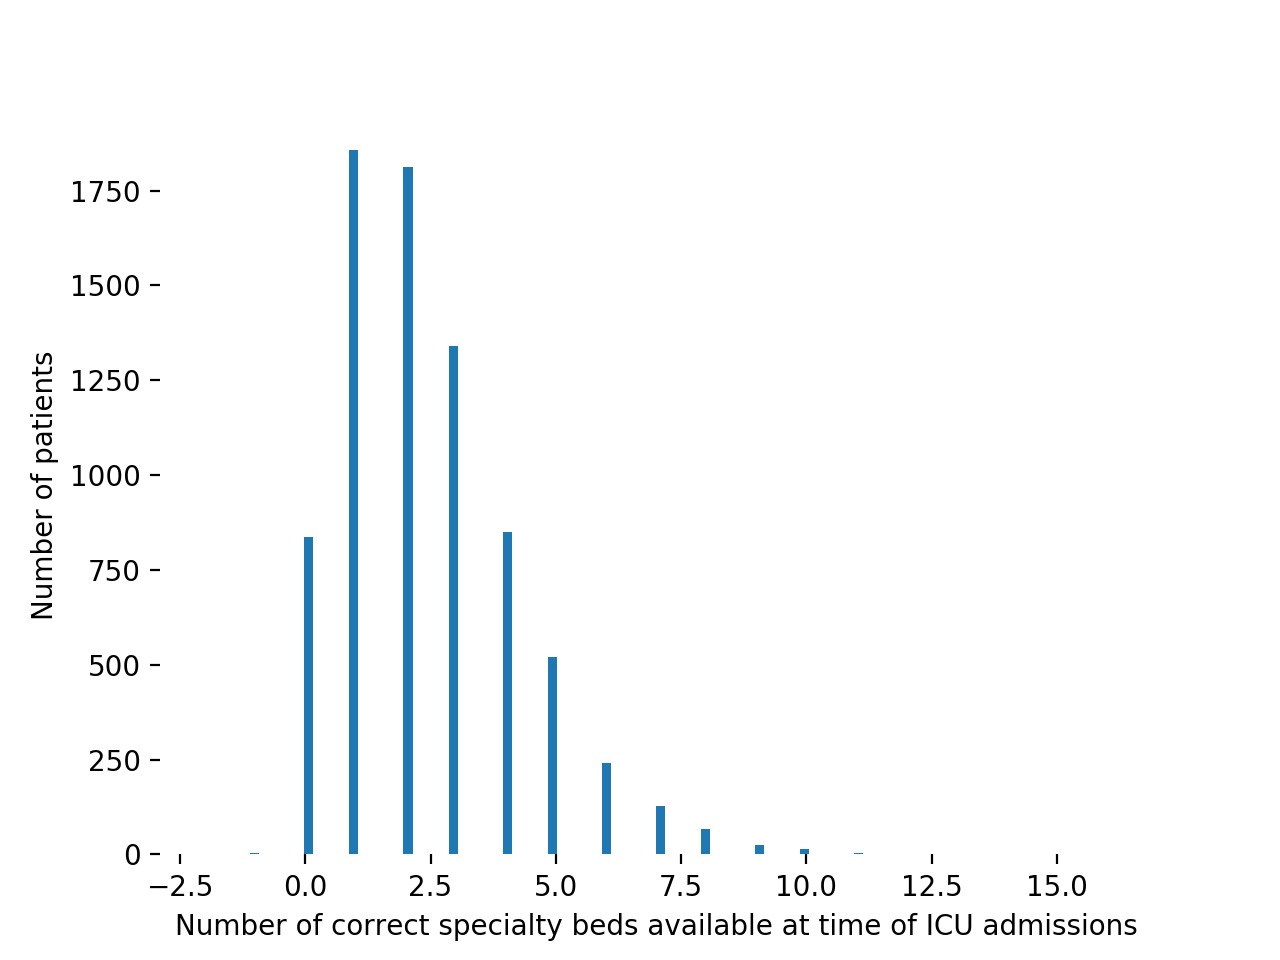

In [30]:
plt.figure()
df['remaining_beds'].hist(bins = 100)
a = plt.gca()
a.grid(False)
a.set_ylabel('Number of patients')
a.set_xlabel('Number of correct specialty beds available at time of ICU admissions')
a.spines['top'].set_visible(False)
a.spines['right'].set_visible(False)
a.spines['bottom'].set_visible(False)
a.spines['left'].set_visible(False)

In [ ]:
simulationStore.append(pd.Series(agreementStore).value_counts())
pd.Series(agreementStore).value_counts()

In [19]:
dayschangedStore

[0.018849742495196043,
 -0.000808792442296857,
 0.0030743803901932907,
 -0.006796943438613712,
 -0.00031469567665447446,
 0.0034175732469111627,
 0,
 0,
 0,
 -0.00010757410384441402,
 0.00674972223609994,
 2.0307680525493573e-05,
 -2.130287816187898e-05,
 0.0061960621263350045,
 -0.002440857181782018,
 0.00020700014217813647,
 0.0016242938886777115,
 -0.0012069679746928585,
 0.0034175732469111627,
 0.0021320904262443125,
 0.0034175732469111627,
 0.006320660807390672,
 0.0014674513154210895,
 0.005775742708176146,
 -0.0018993794553656726,
 0.0036187738554813507,
 0.001834653363522998,
 0.019400297941742025,
 -0.0050659177433174255,
 -0.0028520751432825155,
 0.006123684444162682,
 0,
 0.016839798011641014,
 -0.0036329813922321564,
 0.0069890524675578795,
 0.018327949453720245,
 0.0007353028139707568,
 0.013182301836657202,
 -0.0050659177433174255,
 0.02037303150910233,
 0.012068722199737716,
 0.01030688939589598,
 -0.00337300586027193,
 0.01571364814345198,
 0.008583059998747948,
 0,
 0.

In [20]:
sum(dayschangedStore)/len(dayschangedStore)

0.005217764947813136

In [21]:
sum(dayschangedStore)

40.197661157952396

In [22]:
df = pd.read_csv('data_results.csv')

<IPython.core.display.Javascript object>


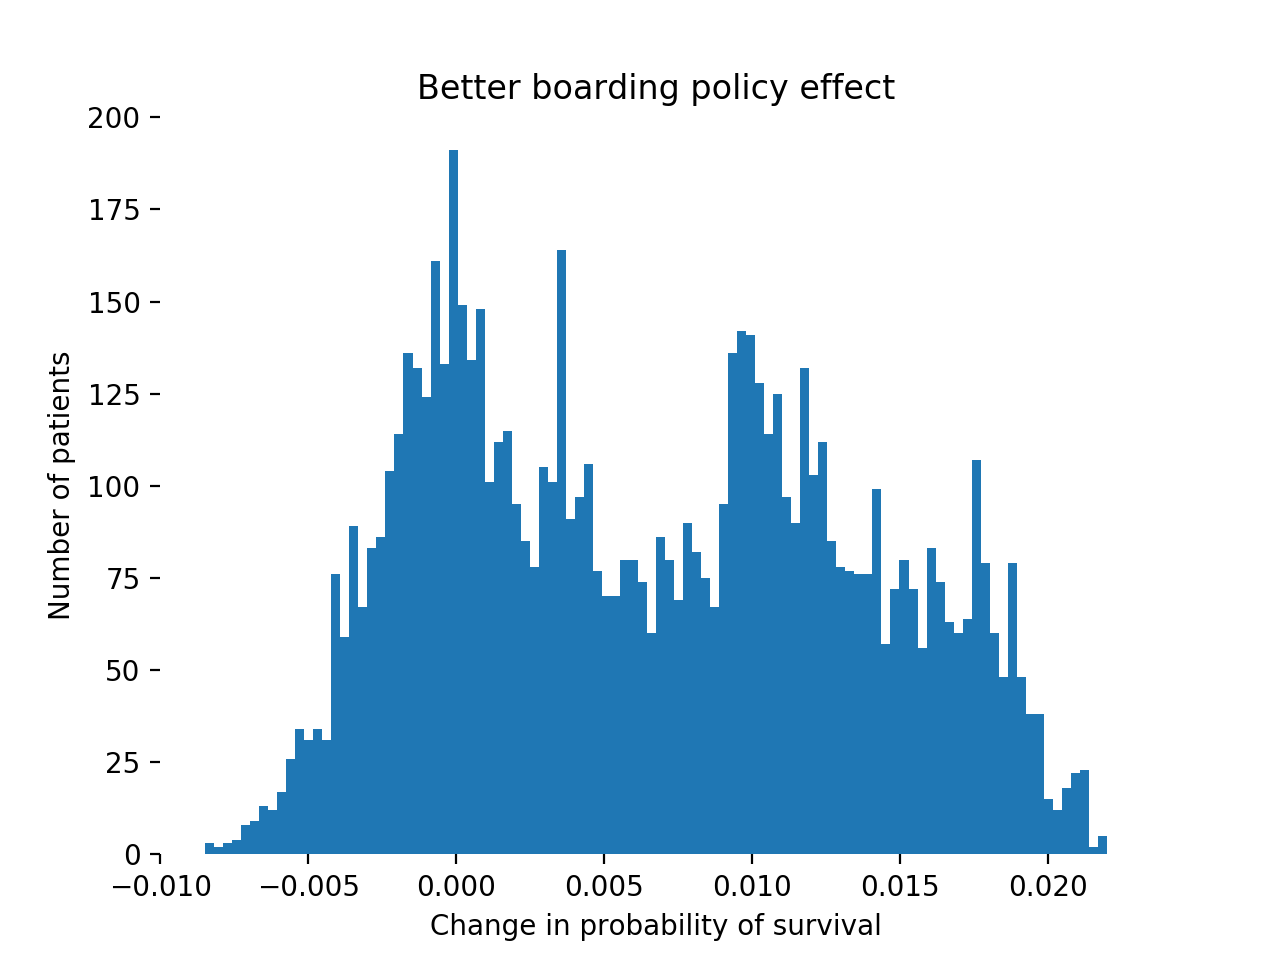

/Users/andrevauvelle/anaconda3/envs/flask/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [33]:
plt.figure()
df.changed_hospital_survival.hist(bins=100)
plt.title("")
plt.grid("off")
a = plt.gca()
a.set_xlabel("Change in probability of survival")
a.set_ylabel("Number of patients")
a.spines['top'].set_visible(False)
a.spines['right'].set_visible(False)
a.spines['bottom'].set_visible(False)
a.spines['left'].set_visible(False)

<IPython.core.display.Javascript object>


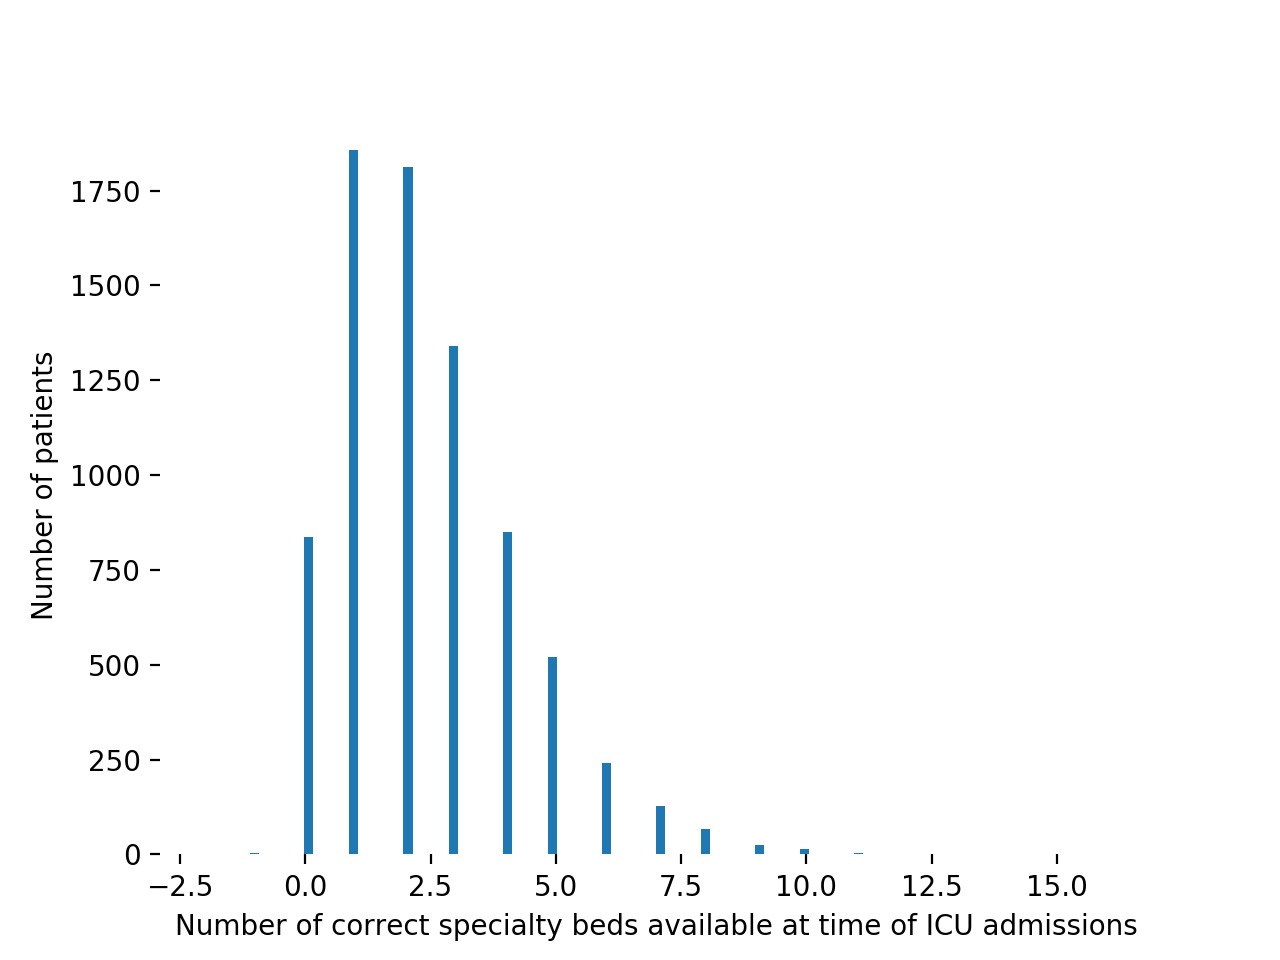

AttributeError: 'DataFrame' object has no attribute 'changed_hospital_survival'

In [27]:
df['dayschangedStore'] = dayschangedStore
plt.figure()
df.changed_hospital_survival.hist(bins=100)
plt.title("Better boarding policy effect")
plt.grid("off")
a = plt.gca()
a.set_xlabel("Change in probability of survival")
a.set_ylabel("Number of patients")
a.spines['top'].set_visible(False)
a.spines['right'].set_visible(False)
a.spines['bottom'].set_visible(False)
a.spines['left'].set_visible(False)

In [26]:
df.dayschangedStore.mean()

0.005217764947813152

In [ ]:
changed_hospital_survival